In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [2]:
# All general imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

import keras
!pip install keras_preprocessing
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Bidirectional, GlobalAveragePooling1D, GRU, GlobalMaxPooling1D, concatenate
from keras.optimizers import Adam
from keras.layers import LSTM, GRU, Conv1D, MaxPool1D, Activation, Add

from keras.models import Model, Sequential
from keras.layers.core import SpatialDropout1D

from keras.layers import Layer, Dense, Input, Embedding, Dropout, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Softmax
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import backend as K

from keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import io, os, gc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [4]:
# Loading drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Setting the working directory
!ls
%cd drive/MyDrive/Project
!pwd

drive  sample_data
/content/drive/MyDrive/Project
/content/drive/MyDrive/Project


In [6]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [7]:
!pip install textstat
!pip install transformers
!pip install nltk
!pip install textblob

!cp drive/MyDrive/Project/Feature_Extractor.py .
from Feature_Extractor import extract_features

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00
cp: cannot stat 'drive/MyDrive/Project/Feature_Extractor.py': No such file or directory
Transformers version:  4.30.2


In [8]:
#################### Importing ByteDance Datasets ####################

le = LabelEncoder()
le2 = LabelEncoder()

# Train set
train_df = pd.read_csv('data/train_bd_with_labels_2nd.csv')
print(train_df.columns)
train_df['bd_label'] = le.fit_transform(train_df['bd_label']) # agreed = 0, disagreed = 1
train_df['single_new_emo'] = le2.fit_transform(train_df['single_new_emo']) # emotions agree = 0, disagree = 1
train_df.head()

# Test set
test_df = pd.read_csv('data/test_bd_with_labels.csv')
print(test_df.columns)
test_df['bd_label'] = le.transform(test_df['bd_label'])
test_df['single_new_emo'] = le2.transform(test_df['single_new_emo'])
test_df.head()

Index(['id', 'title1_en', 'title2_en', 'bd_label', 'quora_label',
       'Premise_Emotion_Label', 'Hypothesis_Emotion_Label', 'com_femotion',
       'femotion', 'NV_Orc', 'EM_Orc', 'weights', 'single_new_emo',
       'premise_emo', 'hypothesis_emo', 'novelty_label'],
      dtype='object')
Index(['id', 'title1_en', 'title2_en', 'bd_label', 'quora_label',
       'Premise_Emotion_Label', 'Hypothesis_Emotion_Label', 'com_femotion',
       'femotion', 'NV_Orc', 'EM_Orc', 'weights', 'test_wts', 'single_new_emo',
       'premise_emo', 'hypothesis_emo', 'novelty_label'],
      dtype='object')


,id,title1_en,title2_en,bd_label,quora_label,Premise_Emotion_Label,Hypothesis_Emotion_Label,com_femotion,femotion,NV_Orc,EM_Orc,weights,test_wts,single_new_emo,premise_emo,hypothesis_emo,novelty_label
0,321198,wanda collapses: china 's richest man wang jia...,news: the detention of wang jianlin and his fa...,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
1,321201,wanda collapses: china 's richest man wang jia...,wang jian 's family is detained,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
2,321200,wanda collapses: china 's richest man wang jia...,Exclusive news: Wang Jian-lin is detained in a...,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
3,321202,wanda collapses: china 's richest man wang jia...,prc: wang jianlin and his family are detained ...,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
4,321205,"The land price 130 thousand, now only needs 33...","$160,000 on the floor. Now it's only $100,000....",0,1,0,0,1,1,1,1,0.544454,0.066667,0,1,1,1


In [9]:
# Importing BERT embeddings
pre_bert_bd = np.load("bert/pre_bert_bd.npy")
hyp_bert_bd = np.load("bert/hyp_bert_bd.npy")
print('Premise', pre_bert_bd.shape)
print('Hypothesis', hyp_bert_bd.shape)

Premise (80992, 768)
Hypothesis (80992, 768)


In [10]:
pre_bert_bd_test = np.load("bert/pre_bert_test_bd.npy")
hyp_bert_bd_test = np.load("bert/hyp_bert_test_bd.npy")
print('Premise', pre_bert_bd_test.shape)
print('Hypothesis', hyp_bert_bd_test.shape)

Premise (28746, 768)
Hypothesis (28746, 768)


In [11]:
# Importing auxiliary features
pre_features_bd = np.load("new_features/pre_features_train_bd.npy")
hyp_features_bd = np.load("new_features/hyp_features_train_bd.npy")
print('Premise', pre_features_bd.shape)
print('Hypothesis', hyp_features_bd.shape)

Premise (80992, 16)
Hypothesis (80992, 16)


In [12]:
pre_features_bd_test = np.load("new_features/pre_features_test_bd.npy")
hyp_features_bd_test = np.load("new_features/hyp_features_test_bd.npy")
print('Premise', pre_features_bd_test.shape)
print('Hypothesis', hyp_features_bd_test.shape)

Premise (28746, 16)
Hypothesis (28746, 16)


In [13]:
train_lst_1 = train_df['title1_en'].tolist()
train_lst_2 = train_df['title2_en'].tolist()
uq_tr_1 = list(set(train_lst_1))
uq_tr_2 = list(set(train_lst_2))
train_merged = uq_tr_1 + uq_tr_2
print('Train length is', len(train_merged))

test_lst_1 = test_df['title1_en'].tolist()
test_lst_2 = test_df['title2_en'].tolist()
uq_ts_1 = list(set(test_lst_1))
uq_ts_2 = list(set(test_lst_2))
test_merged = uq_ts_1 + uq_ts_2
print('Test length is', len(test_merged))

total_dataset = train_merged + test_merged
print('Total dataset length is', len(total_dataset))

Train length is 67950
Test length is 25300
Total dataset length is 93250


In [14]:
train_max_1 = max([len(s) for s in train_lst_1])
train_max_2 = max([len(s) for s in train_lst_2])
train_avg_1 = int(np.average([len(s) for s in train_lst_1]))
train_avg_2 = int(np.average([len(s) for s in train_lst_2]))
train_min_1 = min([len(s) for s in train_lst_1])
train_min_2 = min([len(s) for s in train_lst_2])
print("Train set: ")
print('title1_en -> Max: ', train_max_1, 'Avg: ', train_avg_1, 'Min: ', train_min_1)
print('title2_en -> Max: ', train_max_2, 'Avg: ', train_avg_2, 'Min: ', train_min_2)
test_max_1 = max([len(s) for s in test_lst_1])
test_max_2 = max([len(s) for s in test_lst_2])
test_avg_1 = int(np.average([len(s) for s in test_lst_1]))
test_avg_2 = int(np.average([len(s) for s in test_lst_2]))
test_min_1 = min([len(s) for s in test_lst_1])
test_min_2 = min([len(s) for s in test_lst_2])
print("\nTest set: ")
print('title1_en -> Max: ', test_max_1, 'Avg: ', test_avg_1, 'Min: ', test_min_1)
print('title2_en -> Max: ', test_max_2, 'Avg: ', test_avg_2, 'Min: ', test_min_2)

MAX_LENGTH = 100

Train set: 
title1_en -> Max:  1577 Avg:  93 Min:  6
title2_en -> Max:  4002 Avg:  94 Min:  1

Test set: 
title1_en -> Max:  1050 Avg:  94 Min:  6
title2_en -> Max:  1050 Avg:  95 Min:  1


In [15]:
import string
!pip install nltk
import nltk
from nltk.tokenize import  word_tokenize

contr_dict = {"i\'m" : "i am",
            "won\'t" : "will not",
            "it\'s" : "it is",
            " \'" : " ",
            "\' " : " ",
            "\'s" : "",
            " \'s" : "",
            " s " : " ",
            "\'ll" : "will",
            "\'ve" : "have",
            "n\'t" : "not",
            "\'re" : "are",
            "\'d" : "would",
            "y'all" : "all of you"}

known_typos = dict()

def encode_char(text):
    text = text.replace(u"\u201d",'"') # replace unicode quotation
    text = text.replace(u"\u201c",'"')
    text = text.replace(u"\u2018","'")
    text = text.replace(u"\u2019","'")
    if u"\u201d" in text or u"\u201c" in text or u"\u2018" in text or u"\u2019" in text:
      print(text)
    encoded_string = text.encode("ascii", "ignore")
    text = encoded_string.decode()
    return text

def correct_typos(text):
    text = text + " "
    for typo in known_typos:
      text = text.replace(typo, " "+known_typos[typo])
    return text

def remove_html(text):
    text = text.replace("< i >", "")
    text = text.replace("< / i >", "")
    return text

def remove_numbers(text):
    no_digits = ""
    for i in text:
        if not i.isdigit():
            no_digits += i
    return no_digits

def remove_punctuation(text):
    punctuationfree = ""
    for i in range(len(text)):
      if text[i] not in string.punctuation:
        punctuationfree += text[i]
      else:
        if i < (len(text)-1) and text[i+1] != " ": # add space after punctuation
          punctuationfree += " "
    return punctuationfree

def tokenization(text):
    tokens = word_tokenize(text)
    return tokens

def remove_stopwords(stopwords, tokens):
    result = [t for t in tokens if t not in stopwords]
    return result

def tokens_to_text(tokens):
    result = " ".join(t for t in tokens)
    return result

# remove apostrophes and replaces contractions with full words
def replace_contractions(text, contr_dict=contr_dict):
    text = text.lower()
    for char in ["′","ʼ","`","՚","ʼ","ߴ","ߵ","＇", '“','”',"\'", "’", "‘"]:
      text = text.replace(char, "\'")
    for contr in contr_dict:
      text = text.replace(contr, " "+contr_dict[contr])
    return text

def text_preprocessing(texts):
  new_texts = []
  for text in texts:
      # text = encode_char(text)
      text = remove_html(text)
      text = remove_numbers(text)
      text = replace_contractions(text)
      # text = remove_punctuation(text)
      # text = correct_typos(text)
      # tokens =  tokenization(text)
      # stopwords = nltk.corpus.stopwords.words('english')
      # tokens = remove_stopwords(stopwords, tokens)
      # text = tokens_to_text(tokens)
      new_texts.append(text)
  return new_texts

total_dataset = text_preprocessing(total_dataset)

In [16]:
from nltk import tokenize
import nltk
nltk.download('punkt')

n_sent_lst = []
n_words_lst = []
for text in total_dataset: # count max number of sentences and max number of words in a sentence
  sentences = tokenize.sent_tokenize(text)
  n_sent_lst.append(len(sentences))
  n_words = 0
  for sent in sentences:
    n = len(tokenize.word_tokenize(sent))
    if n > n_words:
      n_words = n
  n_words_lst.append(n_words)

max_n_sent = max(n_sent_lst)
max_n_words = max(n_words_lst)

print(max_n_sent) # max num of sentences
print(max_n_words) # max num of words in a sentence

if max_n_sent > 10:
  m = 10
elif max_n_sent >= 5:
  m = max_n_sent
else:
  m = 5

if max_n_words > 50:
  n = 50
elif max_n_words >= 10:
  n = max_n_words
else:
  n = 10

#MAX_LENGTH = m*n
MAX_LENGTH = 100
print(MAX_LENGTH)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


29
2002
100


In [17]:
# Defining the tokenizer
def get_tokenizer(vocabulary_size):
  print('Training tokenizer...')
  tokenizer = Tokenizer(num_words = vocabulary_size)
  tweet_text = []
  print('Read {} Sentences'.format(len(total_dataset)))
  tokenizer.fit_on_texts(total_dataset)
  return tokenizer

In [18]:
def process_glove_line(line, dim):
    word = None
    embedding = None
    try:
      splitLine = line.split()
      word = " ".join(splitLine[:len(splitLine)-dim])
      embedding = np.array([float(val) for val in splitLine[-dim:]])
    except:
      print(line)
    return word, embedding

# For getting the embedding matrix
def get_embeddings():
  print('Generating embeddings matrix...')
  embeddings_file = 'glove.6B.300d.txt'
  embeddings_index = dict()
  with open(embeddings_file, 'r', encoding="utf-8") as infile:
    for line in infile:
      word, vector = process_glove_line(line, 300)
      embeddings_index[word] = vector
	# create a weight matrix for words in training docs
  vocabulary_size = len(embeddings_index)
  embeddinds_size = list(embeddings_index.values())[0].shape[0]
  print('Vocabulary = {}, embeddings = {}'.format(vocabulary_size, embeddinds_size))
  tokenizer = get_tokenizer(vocabulary_size)
  embedding_matrix = np.zeros((vocabulary_size, embeddinds_size))
  considered = 0
  total = len(tokenizer.word_index.items())
  oov = []
  for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
      print(word, index)
      continue
    else:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        considered += 1
      else:
         oov.append(word)
  print('Considered ', considered, 'Left ', total - considered)
  return embedding_matrix, tokenizer, embeddings_index, oov

In [19]:
def get_data(tokenizer, MAX_LENGTH, input_df):
  print('Loading data')
  X1, X2, Y = [], [], []
  X1 = input_df['title1_en'].tolist()
  X2 = input_df['title2_en'].tolist()
  X1 = text_preprocessing(X1)
  X2 = text_preprocessing(X2)
  # Y_nv = input_df['quora_label'].tolist()
  # Y_em = input_df['com_femotion'].tolist()
  Y_nv = input_df['novelty_label'].tolist()
  Y_em = input_df['single_new_emo'].tolist()
  Y_bd = input_df['bd_label'].tolist()
  assert len(X1) == len(X2) == len(Y_nv) == len(Y_em) == len(Y_bd)
  sequences_1 = tokenizer.texts_to_sequences(X1)
  sequences_2 = tokenizer.texts_to_sequences(X2)
  X1 = pad_sequences(sequences_1, maxlen=MAX_LENGTH)
  X2 = pad_sequences(sequences_2, maxlen=MAX_LENGTH)
  Y_nv = np.array(Y_nv)
  Y_em = np.array(Y_em)
  Y_bd = np.array(Y_bd)
  return X1, X2, Y_nv, Y_em, Y_bd

In [20]:
embedding_matrix, tokenizer, embeddings_index, oov = get_embeddings()

Generating embeddings matrix...
Vocabulary = 400000, embeddings = 300
Training tokenizer...
Read 93250 Sentences
Considered  20896 Left  4009


In [21]:
#print(tokenizer.word_index)

In [22]:
def get_oov_freq(oov, total_dataset):
  oov_freq = dict()
  for s in total_dataset:
    for word in oov:
      count = s.count(word)
      if count > 0:
        try:
          oov_freq[word] += count
        except KeyError:
          oov_freq[word] = count
  return oov_freq

def show_oov_words(oov_freq, num_to_show=30):
    # Sort oov words by their frequency in the text
    sorted_oov = sorted(oov_freq.items(), key=lambda x:x[1], reverse=True)
    # Show oov words and their frequencies
    if (len(sorted_oov)>0):
        print("oov words:")
        for pair in sorted_oov[:num_to_show]:
          print("%s\t%s"%(pair[0], pair[1]))
    else:
        print("No words were out of vocabulary.")
    return len(sorted_oov)

In [23]:
# oov_freq = get_oov_freq(oov, total_dataset)
# oov_len = show_oov_words(oov_freq, 100)

In [24]:
# read ml data
X1, X2, Y_nv, Y_em, Y_bd = get_data(tokenizer, MAX_LENGTH, train_df)

Loading data


Class balance for train data: 


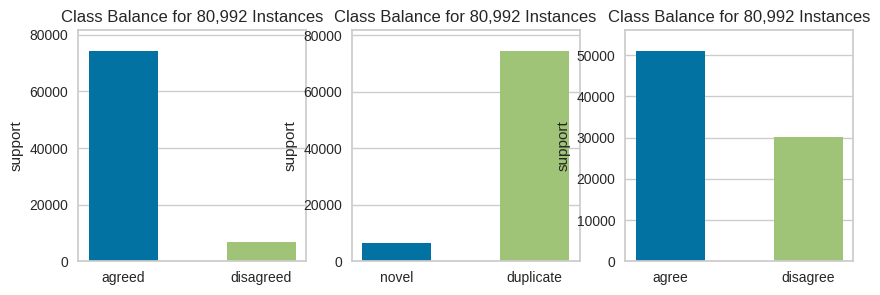

In [25]:
#!pip install yellowbrick
from yellowbrick.target import ClassBalance
import matplotlib.pyplot as plt

print("Class balance for train data: ")
fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(10,3))

classes = le.inverse_transform(np.arange(2))
classes2 = le2.inverse_transform(np.arange(2))

visualiser_bd = ClassBalance(labels=classes, ax=ax1)
visualiser_bd.fit(Y_bd)
visualiser_bd.finalize()

visualiser_nv = ClassBalance(labels=['novel', 'duplicate'], ax=ax2) # 0 = novel, 1 = duplicate
visualiser_nv.fit(Y_nv)
visualiser_nv.finalize()

visualiser_em = ClassBalance(labels=classes2, ax=ax3) # 0 = agree, 1 = disagree
visualiser_em.fit(Y_em)
visualiser_em.finalize()

In [26]:
print("BD train data class balance: ")
unique, counts = np.unique(Y_bd, return_counts=True)
dict(zip(unique, counts))

BD train data class balance: 


{0: 74177, 1: 6815}

In [27]:
X1_test, X2_test, Y_nv_test, Y_em_test, Y_bd_test = get_data(tokenizer, MAX_LENGTH, test_df)

Loading data


Class distribution for test data: 


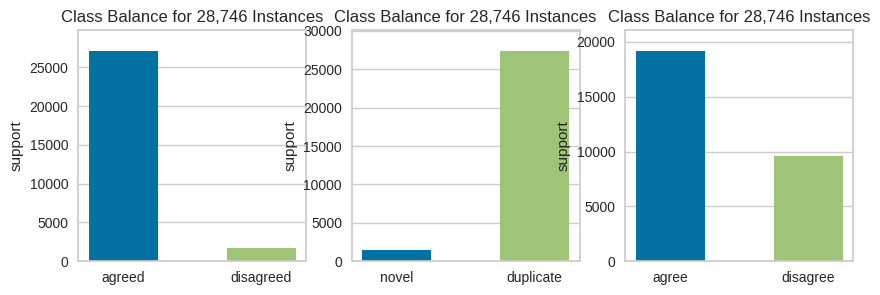

In [28]:
print("Class distribution for test data: ")
fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(10,3))
classes = le.inverse_transform(np.arange(2))
classes2 = le2.inverse_transform(np.arange(2))

visualiser_bd = ClassBalance(labels=classes, ax=ax1)
visualiser_bd.fit(Y_bd_test)
visualiser_bd.finalize()

visualiser_nv = ClassBalance(labels=['novel', 'duplicate'], ax=ax2)
visualiser_nv.fit(Y_nv_test)
visualiser_nv.finalize()

visualiser_em = ClassBalance(labels=classes2, ax=ax3)
visualiser_em.fit(Y_em_test)
visualiser_em.finalize()

In [29]:
print("BD test data class balance: ")
unique, counts = np.unique(Y_bd_test, return_counts=True)
dict(zip(unique, counts))

BD test data class balance: 


{0: 27075, 1: 1671}

In [30]:
# Scaffold labels
novel = embeddings_index['original']
duplicate = embeddings_index['duplicate']
emotion_true = embeddings_index['anticipation']+embeddings_index['sadness']+embeddings_index['joy']+embeddings_index['trust']
emotion_false = embeddings_index['anger']+embeddings_index['fear']+embeddings_index['disgust']+embeddings_index['surprise']

In [31]:
# Novelty Bias
train_bias_nv = []
test_bias_nv = []

for i, row in train_df.iterrows():
    if row['novelty_label'] == 0:
        train_bias_nv.append(novel)
    elif row['novelty_label'] == 1:
        train_bias_nv.append(duplicate)
    else:
        print('Error in Train please check')

for i, row in test_df.iterrows():
    if row['novelty_label'] == 0:
        test_bias_nv.append(novel)
    elif row['novelty_label'] == 1:
        test_bias_nv.append(duplicate)
    else:
        print('Error in Test please check')

train_bias_nv = np.stack(train_bias_nv)
test_bias_nv = np.stack(test_bias_nv)
print('Train bias', train_bias_nv.shape)
print('Test bias', test_bias_nv.shape)

Train bias (80992, 300)
Test bias (28746, 300)


In [32]:
# Emotion Bias
train_bias_em = []
test_bias_em = []
zero_vector = np.zeros((300,))

for i in range(len(train_df)):
    em_lab = train_df.loc[i, 'single_new_emo']
    if train_df.loc[i, 'bd_label'] == 0 and em_lab == 0: # was em_lab == 1
        train_bias_em.append(emotion_false)
    elif train_df.loc[i, 'bd_label'] == 1 and em_lab == 1: # was em_lab == 0
        train_bias_em.append(emotion_true)
    else:
        train_bias_em.append(zero_vector)

for i in range(len(test_df)):
    em_lab = test_df.loc[i, 'single_new_emo']
    if test_df.loc[i, 'bd_label'] == 0 and em_lab == 0: # was em_lab == 1
        test_bias_em.append(emotion_false)
    elif test_df.loc[i, 'bd_label'] == 1 and em_lab == 1: # was em_lab == 0
        test_bias_em.append(emotion_true)
    else:
        test_bias_em.append(zero_vector)

train_bias_em = np.stack(train_bias_em)
test_bias_em = np.stack(test_bias_em)
print('Train bias', train_bias_em.shape)
print('Test bias', test_bias_em.shape)

Train bias (80992, 300)
Test bias (28746, 300)


In [33]:
# Considering the final train and test bias
train_bias = np.add(train_bias_nv, train_bias_em)
test_bias = np.add(test_bias_nv, test_bias_em)

In [34]:
# Creating one-hot encodings
y_train_nv = keras.utils.to_categorical(Y_nv)
# print(y_train_nv)
y_train_em = keras.utils.to_categorical(Y_em)
# print(y_train_em)
y_train_bd = keras.utils.to_categorical(Y_bd)
# print(y_train_bd)
y_test_nv = keras.utils.to_categorical(Y_nv_test)
# print(y_test_nv)
y_test_em = keras.utils.to_categorical(Y_em_test)
# print(y_test_em)
y_test_bd = keras.utils.to_categorical(Y_bd_test)
# print(y_test_bd)

In [35]:
from sklearn.model_selection import train_test_split
VALIDATION_RATIO = 0.1
RANDOM_STATE = 9527
x1_train, x1_val, \
x2_train, x2_val, \
x1_train_bert, x1_val_bert, \
x2_train_bert, x2_val_bert, \
x1_train_features, x1_val_features, \
x2_train_features, x2_val_features, \
y_train_nv, y_val_nv, \
y_train_em, y_val_em, \
y_train_bd, y_val_bd, \
train_bias, val_bias, \
train_bias_nv, val_bias_nv, \
train_bias_em, val_bias_em = \
    train_test_split(
        X1, X2,
        pre_bert_bd, hyp_bert_bd,
        pre_features_bd, hyp_features_bd,
        y_train_nv, y_train_em,
        y_train_bd, train_bias,
        train_bias_nv, train_bias_em,
        test_size=VALIDATION_RATIO,
        random_state=RANDOM_STATE
)

In [36]:
print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"x2_train: {x2_train.shape}")
print(f"x1_train_bert : {x1_train_bert.shape}")
print(f"x2_train_bert : {x2_train_bert.shape}")
print(f"x1_train_features : {x1_train_features.shape}")
print(f"x2_train_features : {x2_train_features.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"x2_val:   {x2_val.shape}")
print(f"x1_val_bert:   {x1_val_bert.shape}")
print(f"x2_val_bert :   {x2_val_bert.shape}")
print(f"x1_val_features:   {x1_val_features.shape}")
print(f"x2_val_features :   {x2_val_features.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (72892, 100)
x2_train: (72892, 100)
x1_train_bert : (72892, 768)
x2_train_bert : (72892, 768)
x1_train_features : (72892, 16)
x2_train_features : (72892, 16)
----------
x1_val:   (8100, 100)
x2_val:   (8100, 100)
x1_val_bert:   (8100, 768)
x2_val_bert :   (8100, 768)
x1_val_features:   (8100, 16)
x2_val_features :   (8100, 16)
----------
Test Set


In [37]:
NUM_CLASSES = 2

MAX_SEQUENCE_LENGTH = MAX_LENGTH

NUM_LSTM_UNITS = 150

MAX_NUM_WORDS = embedding_matrix.shape[0]

NUM_EMBEDDING_DIM = embedding_matrix.shape[1]

In [38]:
class AttentionLayer(Layer):

    def __init__(self,attention_dim=300,return_coefficients=True,**kwargs):
        # Initializer
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape): #(?,100,300)
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def call(self, hit, mask=None):
        # uit = annotations
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        # ait = importance weights per word
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1) # into 1D array
        ait = K.exp(ait)

        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait

        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

In [49]:
## Bi-LSTMs

top_input_wd = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='pre_input') # premise (glove)
bm_input_wd = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='hyp_input') # hypothesis (glove)

top_input_bt = Input(shape=(768, ), dtype='float32', name='pre_input_bert') # premise (bert)
bm_input_bt = Input(shape=(768, ), dtype='float32', name='hyp_input_bert') # hypothesis (bert)

bias_input = Input(shape = (300, ),dtype = 'float32',name='bias_input')
bias_input_nv = Input(shape = (300, ),dtype = 'float32', name='bias_input_nv')
bias_input_em = Input(shape = (300, ),dtype = 'float32', name='bias_input_em')

top_input_aux = Input(shape=(16, ), dtype='float32', name='pre_aux_features') # lexicon and other features (for premise)
bm_input_aux = Input(shape=(16, ), dtype='float32', name='hyp_aux_features') # lexicon and other features (for hypothesis)

# Embedding layer of LSTM based model
embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM, weights = [embedding_matrix], trainable = True, name='embedding')
top_embedded_wd = embedding_layer(top_input_wd)
bm_embedded_wd = embedding_layer(bm_input_wd)

# first Bi-LSTM
source_lstm_wd = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, recurrent_dropout = 0.3, name="lstm_1"),name='bi_1')
top_source_wd = source_lstm_wd(top_embedded_wd)
bm_source_wd = source_lstm_wd(bm_embedded_wd)

# dense layer
dense_layer_1 = Dense(300, activation='relu', name='dense_1')
top_source_wd_dense = dense_layer_1(top_source_wd)
bm_source_wd_dense = dense_layer_1(bm_source_wd)

# concatenating hidden representations of premise and hypothesis
source_comb_wd = concatenate([top_source_wd_dense, bm_source_wd_dense],axis=-1, name='concat_pre_hyp')

# second Bi-LSTM
shared_lstm_wd = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, return_state=True, activation='tanh', recurrent_dropout = 0.3, name="lstm_2"),name='bi_2')
(lstm_ops_wd, forward_h, forward_c, backward_h, backward_c) = shared_lstm_wd(source_comb_wd) # (None, 100, 600)

# dense layer
dense_layer_2 = Dense(300, activation='relu', name='dense_2')
lstm_ops_wd_dense = dense_layer_2(lstm_ops_wd)

# attention layer
seq_att, seq_coeffs = AttentionLayer(NUM_EMBEDDING_DIM,return_coefficients=True,name='attention')(lstm_ops_wd_dense)
context_vector_wd = Dropout(0.4,name='dropout')(seq_att)



# BERT Embeddings
top_embedded_bt = Reshape((1, 768, ),name='reshape_pre_bert')(top_input_bt)
bm_embedded_bt = Reshape((1, 768, ),name='reshape_hyp_bert')(bm_input_bt)

# first Bi-LSTMs
source_lstm_bt = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, recurrent_dropout = 0.3, name="lstm_bert_1"),name='bi_bert_1')
top_source_bt = source_lstm_bt(top_embedded_bt)
bm_source_bt = source_lstm_bt(bm_embedded_bt)

# dense layer
dense_layer_3 = Dense(300, activation='relu', name='dense_3')
top_source_bt_dense = dense_layer_3(top_source_bt)
bm_source_bt_dense = dense_layer_3(top_source_bt)

# concatenat premise and hypothesis
source_comb_bt = concatenate([top_source_bt, bm_source_bt],axis=-1,name='concat_pre_hyp_bert')

# second Bi-LSTM
shared_lstm_bt = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, return_state=True, activation='tanh', recurrent_dropout = 0.3, name="lstm_bert_2"),name='bi_bert_2')
(lstm_ops_bt, forward_h, forward_c, backward_h, backward_c) = shared_lstm_bt(source_comb_bt)

# dense layer
dense_layer_4 = Dense(300, activation='relu', name='dense_4')
lstm_ops_bt_dense = dense_layer_4(lstm_ops_bt)

# attention layer
seq_att_bt, seq_coeffs_bt = AttentionLayer(NUM_EMBEDDING_DIM,return_coefficients=True,name='attention_bert')(lstm_ops_bt_dense)
context_vector_bt = Dropout(0.4,name='dropout_bert')(seq_att_bt) # (None, 300)



# concatenate new features of premise and hypothesis
comb_aux_features = concatenate([top_input_aux, bm_input_aux],name='concat_pre_hyp_aux')



# concatenation layer

# novelty and emotion tasks
comb_features = concatenate([context_vector_wd+context_vector_bt, \
                             context_vector_wd-context_vector_bt, \
                             context_vector_wd*context_vector_bt, \
                             comb_aux_features],axis=-1,name='concat_nv_em_features')

# fake news detection
comb_features_bd = concatenate([context_vector_wd+context_vector_bt+bias_input, \
                                context_vector_wd*context_vector_bt*bias_input, \
                                comb_aux_features],axis=-1,name='concat_bd_features')


# task-specific networks
pre_nv = Dense(units=64, activation='tanh', name='dense_nv')(comb_features)
pre_em = Dense(units=64, activation='tanh', name='dense_em')(comb_features)
pre_bd = Dense(units=64, activation='tanh', name='dense_bd')(comb_features_bd)

# prediction
dense_nv =  Dense(units=NUM_CLASSES, activation='softmax',name = 'nv')
dense_em =  Dense(units=NUM_CLASSES, activation='softmax',name = 'em')
dense_bd =  Dense(units=NUM_CLASSES, activation='softmax',name = 'bd')

# outputs
predictions_nv = dense_nv(pre_nv)
predictions_em = dense_em(pre_em)
predictions_bd = dense_bd(pre_bd)

model_lstm = Model(
    inputs=[top_input_wd, bm_input_wd, top_input_bt, bm_input_bt, bias_input, bias_input_nv, bias_input_em, top_input_aux, bm_input_aux],
    outputs=[predictions_nv, predictions_em, predictions_bd])

model_lstm.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pre_input (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 hyp_input (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     120000000   ['pre_input[0][0]',              
                                                                  'hyp_input[0][0]']              
                                                                                                  
 pre_input_bert (InputLayer)    [(None, 768)]        0           []                         

In [50]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
lr = 0.001
opt = Adam(lr=lr, decay=lr/50)
model_lstm.compile(
    optimizer=opt,
    loss={'nv':'categorical_crossentropy', 'em':'categorical_crossentropy', 'bd':'categorical_crossentropy'},
    loss_weights={'nv': 1, 'em':1, 'bd': 1},
    metrics=['accuracy'])
keras.utils.plot_model(model_lstm, "model_bilstm_bd.png", show_shapes=True)
checkpointer = ModelCheckpoint(filepath='multitask_bd_v2.h5', verbose=1, save_best_only=True)

In [ ]:
# MultiTask Model
BATCH_SIZE = 256
NUM_EPOCHS = 50
stop = [EarlyStopping(monitor='val_loss', patience=0.001)]
history = model_lstm.fit(x=[x1_train, x2_train, x1_train_bert, x2_train_bert, train_bias, train_bias_nv, train_bias_em, x1_train_features, x2_train_features],
                    y=[y_train_nv, y_train_em, y_train_bd],
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(
                      [x1_val, x2_val, x1_val_bert, x2_val_bert, val_bias, val_bias_nv, val_bias_em, x1_val_features, x2_val_features],
                      [y_val_nv, y_val_em, y_val_bd]
                    ),
                    shuffle=True,
                    callbacks=stop,
          )

Epoch 1/50
285/285 [==============================] - 498s 2s/step - loss: 0.8278 - nv_loss: 0.1350 - em_loss: 0.6652 - bd_loss: 0.0275 - nv_accuracy: 0.9581 - em_accuracy: 0.6211 - bd_accuracy: 0.9927 - val_loss: 0.7365 - val_nv_loss: 0.0647 - val_em_loss: 0.6570 - val_bd_loss: 0.0149 - val_nv_accuracy: 0.9821 - val_em_accuracy: 0.6275 - val_bd_accuracy: 0.9968
Epoch 2/50
285/285 [==============================] - 467s 2s/step - loss: 0.7137 - nv_loss: 0.0536 - em_loss: 0.6486 - bd_loss: 0.0116 - nv_accuracy: 0.9849 - em_accuracy: 0.6263 - bd_accuracy: 0.9972 - val_loss: 0.7010 - val_nv_loss: 0.0510 - val_em_loss: 0.6365 - val_bd_loss: 0.0134 - val_nv_accuracy: 0.9854 - val_em_accuracy: 0.6307 - val_bd_accuracy: 0.9972
Epoch 3/50
285/285 [==============================] - 466s 2s/step - loss: 0.6542 - nv_loss: 0.0381 - em_loss: 0.6068 - bd_loss: 0.0093 - nv_accuracy: 0.9895 - em_accuracy: 0.6469 - bd_accuracy: 0.9976 - val_loss: 0.6506 - val_nv_loss: 0.0453 - val_em_loss: 0.5928 - val

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
predictions = model_lstm.predict(
    [X1_test, X2_test, pre_bert_bd_test, hyp_bert_bd_test, test_bias, test_bias_nv, test_bias_em, pre_features_bd_test, hyp_features_bd_test])

899/899 [==============================] - 166s 182ms/step


In [ ]:
print(np.stack(predictions).shape)
print(predictions[0].shape)
print(predictions[1].shape)
print(predictions[2].shape)

(3, 28746, 2)
(28746, 2)
(28746, 2)
(28746, 2)


In [ ]:
# Result Labels
res_df = pd.DataFrame()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):

    # Loss
    fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
    losses = ['bd_loss','nv_loss','em_loss']
    i = 0
    for ax in [ax1, ax2, ax3]:
      ax.plot(history.history[losses[i]], 'g')
      ax.set_title(losses[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel('loss')
      i += 1

    plt.show()

    # Accuracy
    fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
    losses = ['bd_accuracy','nv_accuracy','em_accuracy']
    i = 0
    for ax in [ax1, ax2, ax3]:
      ax.plot(history.history[losses[i]], 'b')
      ax.set_title(losses[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel('loss')
      i += 1

    plt.show()

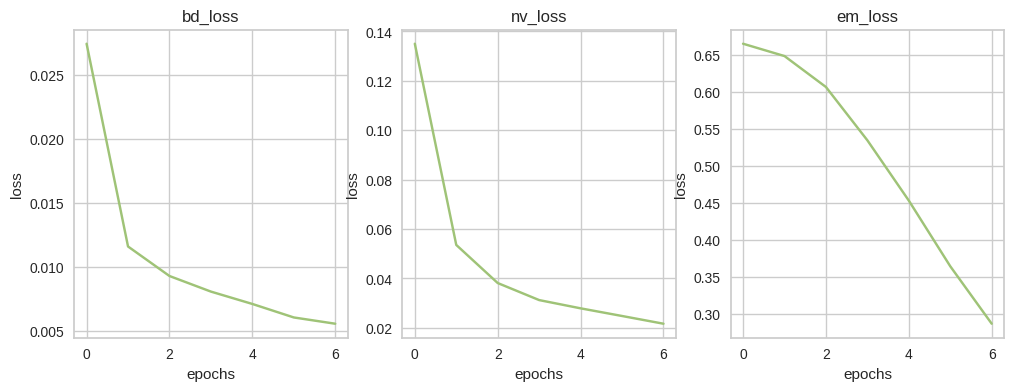

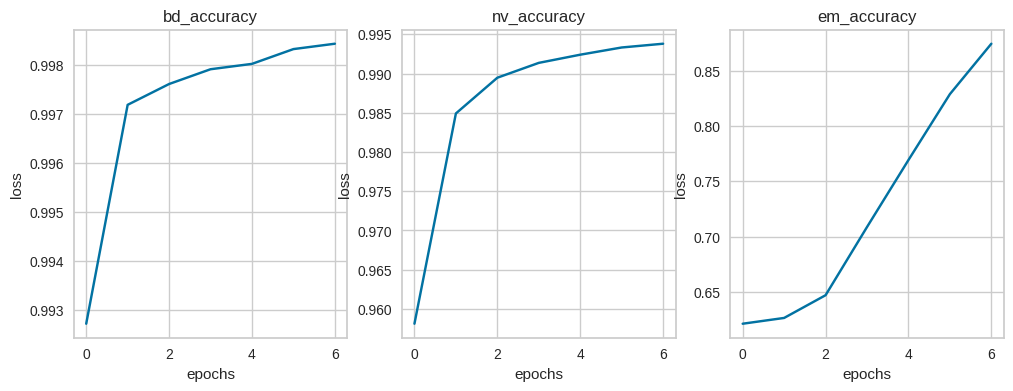

In [ ]:
#print(history.history['bd_loss'])
plot_history(history)

In [ ]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
y_pred = [idx for idx in np.argmax(predictions[2], axis=1)]
res_df['Fake_News_Labels'] = y_pred
#print(y_pred)
print('BD Accuracy is')
print(metrics.accuracy_score(Y_bd_test, y_pred)*100)
print(classification_report(Y_bd_test, y_pred, target_names = ['agreed', 'disagreed']))

BD Accuracy is
99.26946357754123
              precision    recall  f1-score   support

      agreed       0.99      1.00      1.00     27075
   disagreed       0.96      0.91      0.94      1671

    accuracy                           0.99     28746
   macro avg       0.98      0.95      0.97     28746
weighted avg       0.99      0.99      0.99     28746



[[27017    58]
 [  152  1519]]


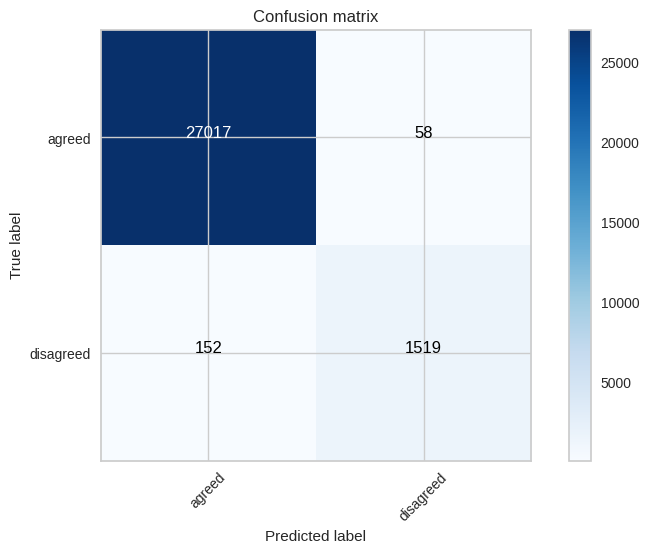

In [ ]:
cnf_matrix = confusion_matrix(Y_bd_test,y_pred)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=le.inverse_transform(np.arange(2)))

In [ ]:
y_pred = [idx for idx in np.argmax(predictions[1], axis=1)]
res_df['Emotion_Labels'] = y_pred
#print(y_pred)
print('Emotion Accuracy is')
print(metrics.accuracy_score(Y_em_test, y_pred)*100)
print(classification_report(Y_em_test, y_pred, target_names = ['agree', 'disagree']))

Emotion Accuracy is
69.76970708968204
              precision    recall  f1-score   support

       agree       0.78      0.77      0.77     19132
    disagree       0.55      0.56      0.55      9614

    accuracy                           0.70     28746
   macro avg       0.66      0.66      0.66     28746
weighted avg       0.70      0.70      0.70     28746



[[14648  4484]
 [ 4206  5408]]


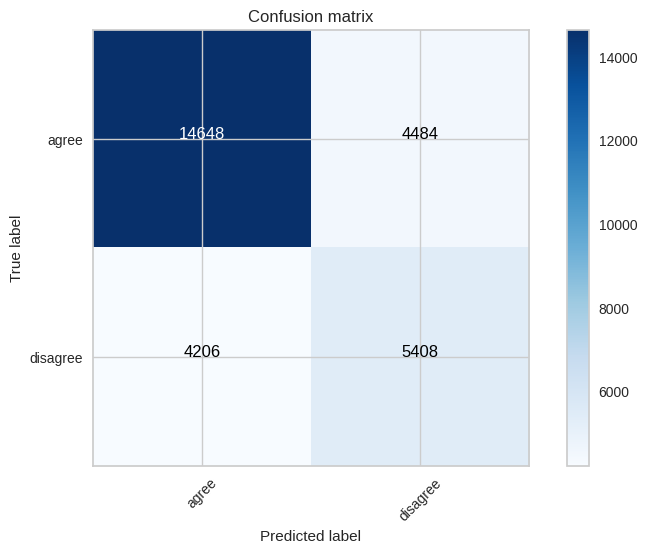

In [ ]:
cnf_matrix = confusion_matrix(Y_em_test,y_pred)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=['agree','disagree'])

In [ ]:
y_pred = [idx for idx in np.argmax(predictions[0], axis=1)]
res_df['Novelty_Labels'] = y_pred
#print(y_pred)
print('NV Accuracy is')
print(metrics.accuracy_score(Y_nv_test, y_pred)*100)
print(classification_report(Y_nv_test, y_pred, target_names = ['novel', 'duplicate']))

NV Accuracy is
96.7195435886732
              precision    recall  f1-score   support

       novel       0.65      0.72      0.68      1405
   duplicate       0.99      0.98      0.98     27341

    accuracy                           0.97     28746
   macro avg       0.82      0.85      0.83     28746
weighted avg       0.97      0.97      0.97     28746



[[ 1017   388]
 [  555 26786]]


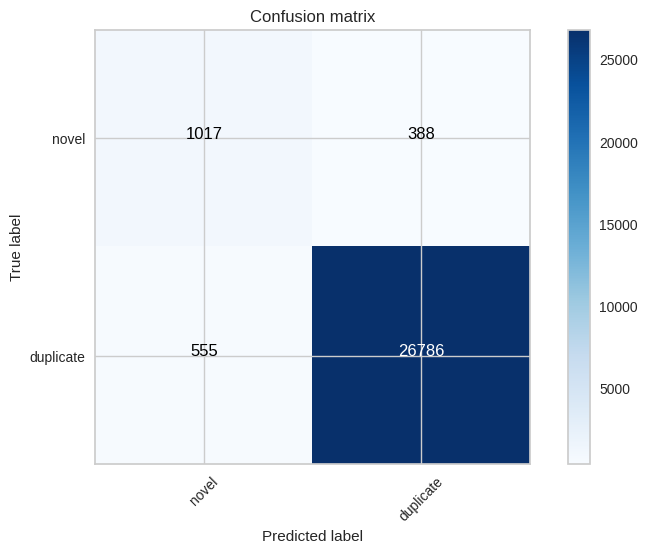

In [ ]:
cnf_matrix = confusion_matrix(Y_nv_test,y_pred)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=['novel','duplicate'])

In [ ]:
# Saving the labels
res_df.to_csv("BD_Multitask_results.csv", index = False)

In [ ]:
## Multitask model for only disagreement detection and emotion recognition

top_input_wd = Input( # top-lstm (for premise)
    shape=(MAX_SEQUENCE_LENGTH, ),
    dtype='int32')
bm_input_wd = Input( # bottom-lstm (for hypothesis)
    shape=(MAX_SEQUENCE_LENGTH, ),
    dtype='int32')

top_input_bt = Input( # top-bert (for premise)
    shape=(768, ),
    dtype='float32')
bm_input_bt = Input( # bottom-bert (for hypothesis)
    shape=(768, ),
    dtype='float32')

# bias_input = Input(
#     shape = (300, ),
#     dtype = 'float32')
bias_input_em = Input(
    shape = (300, ),
    dtype = 'float32')

top_input_aux = Input( # lexicon and other features (for premise)
    shape=(16, ),
    dtype='float32')
bm_input_aux = Input( # lexicon and other features (for hypothesis)
    shape=(16, ),
    dtype='float32')

# Embedding layer of LSTM based model
embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM, weights = [embedding_matrix], trainable = True)
top_embedded_wd = embedding_layer(top_input_wd)
bm_embedded_wd = embedding_layer(bm_input_wd)

# first Bi-LSTM
source_lstm_wd = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, recurrent_dropout = 0.3), name="source_bi_lstm")
top_source_wd = source_lstm_wd(top_embedded_wd)
bm_source_wd = source_lstm_wd(bm_embedded_wd) # (None, 100, 300)

# dense layer
dense_layer_1 = Dense(300, activation='relu', name='dense_1')
top_source_wd_dense = dense_layer_1(top_source_wd)
bm_source_wd_dense = dense_layer_1(bm_source_wd)

# concatenating hidden representations of premise and hypothesis
source_comb_wd = concatenate([top_source_wd_dense, bm_source_wd_dense],axis=-1) # (None, 100, 600)

# second Bi-LSTM
shared_lstm_wd = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, return_state=True, activation='tanh', recurrent_dropout = 0.3), name="shared_bi_lstm")
(lstm_ops_wd, forward_h, forward_c, backward_h, backward_c) = shared_lstm_wd(source_comb_wd) # (None, 100, 600)

# dense layer
dense_layer_2 = Dense(300, activation='relu', name='dense_2')
lstm_ops_wd_dense = dense_layer_2(lstm_ops_wd) # (None, 100, 300)

# attention layer
seq_att, seq_coeffs = AttentionLayer(NUM_EMBEDDING_DIM,return_coefficients=True,name='attention_wd')(lstm_ops_wd_dense)
context_vector_wd = Dropout(0.4,name='dropout_wd')(seq_att) # (None, 300)


# BERT Embeddings
top_embedded_bt = Reshape((1, 768, ))(top_input_bt)
bm_embedded_bt = Reshape((1, 768, ))(bm_input_bt)

# first Bi-LSTMs
source_lstm_bt = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, recurrent_dropout = 0.3, name="source_lstm_bert"))
top_source_bt = source_lstm_bt(top_embedded_bt)
bm_source_bt = source_lstm_bt(bm_embedded_bt)

# dense layer
dense_layer_3 = Dense(300, activation='relu', name='dense_3')
top_source_bt_dense = dense_layer_3(top_source_bt)
bm_source_bt_dense = dense_layer_3(top_source_bt)

# concatenat premise and hypothesis
source_comb_bt = concatenate([top_source_bt, bm_source_bt],axis=-1)

# second Bi-LSTM
shared_lstm_bt = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, return_state=True, activation='tanh', recurrent_dropout = 0.3, name="shared_lstm_bert"))
(lstm_ops_bt, forward_h, forward_c, backward_h, backward_c) = shared_lstm_bt(source_comb_bt)

# dense layer
dense_layer_4 = Dense(300, activation='relu', name='dense_4')
lstm_ops_bt_dense = dense_layer_4(lstm_ops_bt)

# attention layer
seq_att_bt, seq_coeffs_bt = AttentionLayer(NUM_EMBEDDING_DIM,return_coefficients=True,name='attention_bt')(lstm_ops_bt_dense)
context_vector_bt = Dropout(0.4,name='dropout_bt')(seq_att_bt) # (None, 300)


# concatenate new features of premise and hypothesis
comb_aux_features = concatenate([top_input_aux, bm_input_aux])


# concatenation layer

# emotion recognition
comb_features = concatenate([context_vector_wd+context_vector_bt, \
                             context_vector_wd-context_vector_bt, \
                             context_vector_wd*context_vector_bt, \
                             comb_aux_features],axis=-1)

# fake news detection
comb_features_bd = concatenate([context_vector_wd+context_vector_bt+bias_input_em, \
                                context_vector_wd*context_vector_bt*bias_input_em, \
                                comb_aux_features],axis=-1)
# comb_features_bd = concatenate([context_vector_wd+context_vector_bt, context_vector_wd*context_vector_bt],axis=-1)


# task-specific networks
pre_em = Dense(units=64, activation='tanh', name = 'pre_em')(comb_features)
pre_bd = Dense(units=64, activation='tanh',name = 'pre_bd')(comb_features_bd)

# prediction
dense_em =  Dense(units=NUM_CLASSES, activation='softmax',name = 'em')
dense_bd =  Dense(units=NUM_CLASSES, activation='softmax',name = 'bd')

# outputs
predictions_em = dense_em(pre_em)
predictions_bd = dense_bd(pre_bd)

model_dg_em = Model(
    inputs=[top_input_wd, bm_input_wd, top_input_bt, bm_input_bt, bias_input_em, top_input_aux, bm_input_aux],
    outputs=[predictions_em, predictions_bd])

model_dg_em.summary()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 300)     120000000   ['input_10[0][0]',               
                                                                  'input_11[0][0]']               
                                                                                                  
 input_12 (InputLayer)          [(None, 768)]        0           []                         

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
lr = 0.001
opt = Adam(lr=lr, decay=lr/50)
model_dg_em.compile(
    optimizer=opt,
    loss={'em':'categorical_crossentropy', 'bd':'categorical_crossentropy'},
    loss_weights={'em':1, 'bd':1},
    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='multitask_dg_em_bd.h5', verbose=1, save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Disagreement detection and emotion recognition
BATCH_SIZE = 256
NUM_EPOCHS = 50
stop = [EarlyStopping(monitor='val_loss', patience=0.001)]
history = model_dg_em.fit(x=[x1_train, x2_train, x1_train_bert, x2_train_bert, train_bias_em, x1_train_features, x2_train_features],
                    y=[y_train_em, y_train_bd],
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(
                      [x1_val, x2_val, x1_val_bert, x2_val_bert, val_bias_em, x1_val_features, x2_val_features],
                      [y_val_em, y_val_bd]
                    ),
                    shuffle=True,
                    callbacks=stop,
          )

Epoch 1/50
285/285 [==============================] - 437s 1s/step - loss: 0.7238 - em_loss: 0.6586 - bd_loss: 0.0653 - em_accuracy: 0.6220 - bd_accuracy: 0.9776 - val_loss: 0.6904 - val_em_loss: 0.6527 - val_bd_loss: 0.0377 - val_em_accuracy: 0.6293 - val_bd_accuracy: 0.9900
Epoch 2/50
285/285 [==============================] - 406s 1s/step - loss: 0.6316 - em_loss: 0.6054 - bd_loss: 0.0262 - em_accuracy: 0.6489 - bd_accuracy: 0.9926 - val_loss: 0.6015 - val_em_loss: 0.5713 - val_bd_loss: 0.0302 - val_em_accuracy: 0.6907 - val_bd_accuracy: 0.9914
Epoch 3/50
285/285 [==============================] - 411s 1s/step - loss: 0.4809 - em_loss: 0.4658 - bd_loss: 0.0151 - em_accuracy: 0.7719 - bd_accuracy: 0.9953 - val_loss: 0.4567 - val_em_loss: 0.4350 - val_bd_loss: 0.0217 - val_em_accuracy: 0.8049 - val_bd_accuracy: 0.9947
Epoch 4/50
285/285 [==============================] - 411s 1s/step - loss: 0.3092 - em_loss: 0.3011 - bd_loss: 0.0082 - em_accuracy: 0.8718 - bd_accuracy: 0.9975 - val_l

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
predictions = model_dg_em.predict(
    [X1_test, X2_test, pre_bert_bd_test, hyp_bert_bd_test, test_bias_em, pre_features_bd_test, hyp_features_bd_test])

899/899 [==============================] - 168s 184ms/step


In [ ]:
print(np.stack(predictions).shape)
print(predictions[0].shape)
print(predictions[1].shape)

(2, 28746, 2)
(28746, 2)
(28746, 2)


In [ ]:
res_df_2 = pd.DataFrame()

In [ ]:
y_pred = [idx for idx in np.argmax(predictions[1], axis=1)]
res_df_2['Fake_News_Labels'] = y_pred
print('BD Accuracy is')
print(metrics.accuracy_score(Y_bd_test, y_pred)*100)
print(classification_report(Y_bd_test, y_pred, target_names = ['agreed', 'disagreed']))

BD Accuracy is
98.75113059208238
              precision    recall  f1-score   support

      agreed       1.00      0.99      0.99     27075
   disagreed       0.85      0.95      0.90      1671

    accuracy                           0.99     28746
   macro avg       0.92      0.97      0.95     28746
weighted avg       0.99      0.99      0.99     28746



In [ ]:
y_pred = [idx for idx in np.argmax(predictions[0], axis=1)]
res_df_2['Emotion_Labels'] = y_pred
print('Emotion Accuracy is')
print(metrics.accuracy_score(Y_em_test, y_pred)*100)
print(classification_report(Y_em_test, y_pred, target_names = ['agree', 'disagree']))

Emotion Accuracy is
78.91880609476101
              precision    recall  f1-score   support

       agree       0.85      0.83      0.84     19132
    disagree       0.68      0.71      0.69      9614

    accuracy                           0.79     28746
   macro avg       0.76      0.77      0.77     28746
weighted avg       0.79      0.79      0.79     28746

